# Proizvodnja i potrošnja el. energije

Potrošnja električne energije je posmatrana sa dva aspekta:
Prvobitni podaci su prikupljeni sa stranice ENTSO-e za 2016., 2017. i 2018. godinu, te je uključen i dodatni fajl koji je dobijen od NOS BiH, a koji uključuje podatke o konzumu i gubicima za 2019., 2020. i 2021. godinu. Ovaj dio čini DIO A. DIO B je dobijen automatizacijom skidanja podataka sa stranice NOS BiH https://www.nosbih.ba/bs/ees/graf-potrosnje/ i pored potrošnje, sadrži i podatke o proizvodnji, te planiranoj potrošnji i proizvodnji za 2020. i 2021. godinu. Podaci za 2019. godinu nisu dostupni, kao i za neke dane u 2020. i 2021. godini.

## DIO A

### Podaci za 2016., 2017., 2018.

Dio satnih podataka potrošnje električne energije je pronađen na web-stranici https://www.entsoe.eu/. Ovi podaci su spašeni u fajlu "MHLV_data-2015-2017.xlsx") i sastoji se od dva lista, gdje se prvi odnosi na godine 2016,2017, a drugi list na 2018. i djelimično 2019. Fajl sadrži podatke za više država, te je prvo potrebno uraditi filtriranje podataka sa kodom "BA" koji se odnosi na Bosnu i Hercegovinu. U ovom fajlu nisu navedeni gubici, ali su se vrijednosti nasumično upoređivale sa fajlom dostavljenim iz NOSBiH, te se na osnovu toga zaključilo da su gubici već oduzeti od ukupne snage konzuma.

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt

In [3]:
file=pd.read_excel(r"FILES\ELEKT\MHLV_data-2015-2017.xlsx",header=0,sheet_name=1)
file2=pd.read_excel(r"FILES\ELEKT\MHLV_data-2015-2017.xlsx",header=0,sheet_name=0)

In [4]:
def filter_countrycode(filename,name):
    return filename[filename["CountryCode"]==name]

In [5]:
BA_file=filter_countrycode(file,"BA") #2018,2019
BA_file2=filter_countrycode(file2,"BA") # 2016,2017

U oba fajla su napravljene nove kolone koje sadržavaju: godinu, sat, mjesec, dan u godini i dan u sedmici. 

In [6]:
def assign_datetime(filename):
    filename=filename.assign(Godina=filename["DateUTC"].dt.year)
    filename=filename.assign(Sat=filename["DateUTC"].dt.hour)
    filename=filename.assign(Mjesec=filename["DateUTC"].dt.month)
    filename=filename.assign(Dan_u_godini=filename["DateUTC"].dt.dayofyear)
    filename=filename.assign(Dan_u_sedmici=filename["DateUTC"].dt.dayofweek)
    filename=filename.assign(Dan_u_mjesecu=filename["DateUTC"].dt.day)
    return filename

In [7]:
BA_file=assign_datetime(BA_file)
BA_file2=assign_datetime(BA_file2)

(600000.0, 1311807.5424999995)

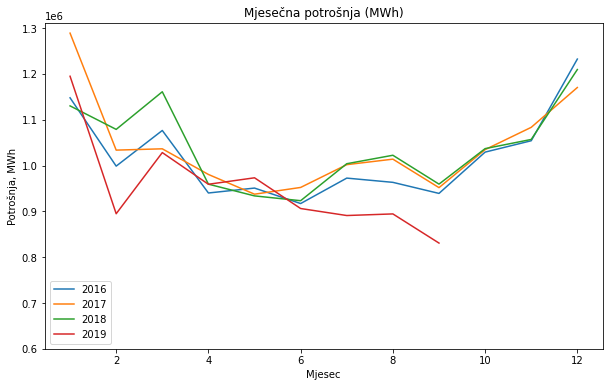

In [8]:
fig = plt.figure(figsize=(10,6))


BA_file2[BA_file2["Godina"]==2016].groupby("Mjesec")["Value"].sum().plot(label="2016")
BA_file2[BA_file2["Godina"]==2017].groupby("Mjesec")["Value"].sum().plot(label="2017")

BA_file[BA_file["Godina"]==2018].groupby("Mjesec")["Value"].sum().plot(label="2018")
BA_file[BA_file["Godina"]==2019].groupby("Mjesec")["Value"].sum().plot(label="2019")
plt.legend()
plt.xlabel("Mjesec")
plt.ylabel("Potrošnja, MWh")
plt.title("Mjesečna potrošnja (MWh)")
plt.ylim(bottom=600000)

### Podaci za 2018., 2019., 2020.  i obrada za dalju analizu

Nezavisni operator sistema (NOS BiH) je ustupio podatke o potrošnji el. energije za 2018., 2019. i 2020. godinu, uz satne gubitke električne energije.  S obzirom da ovi fajlovi sadrže i gubitke i da su podaci za 2019. potpuni, za 2018. i 2019. se neće koristiti podaci od entso-e, već podaci dobiveni od NOS BiH. Ovi podaci su spašeni u fajlu "Konzum 01.18-12.20.xlsx" u tri različita lista. Pošto kolona "Datum" nije u punom vremenskom formatu (sat dat u obliku 00-01), potrebno je prvo izvršiti pretvaranje u vremenski format kako bi podaci bili uporedivi sa onim dostupnim iz prethodnih koraka. 

In [9]:
file3_2018=pd.read_excel(r"FILES\ELEKT\Konzum 01.18-12.20.xlsx",header=(0,1),sheet_name=0)
file3_2019=pd.read_excel(r"FILES\ELEKT\Konzum 01.18-12.20.xlsx",header=(0,1),sheet_name=1)
file3_2020=pd.read_excel(r"FILES\ELEKT\Konzum 01.18-12.20.xlsx",header=(0,1),sheet_name=2)

In [10]:
file3_2018.columns

MultiIndex([(           'Datum', 'Unnamed: 0_level_1'),
            (          'Konzum',                'kWh'),
            (          'Gubici',                'MWh'),
            (          'Gubici',              'MWh.1'),
            ('Gubici + Konzum ',                'kWh')],
           )

In [11]:
new_columns=["Datum", "Konzum, kWh","Gubici, MWh", "Gubici, MWh.1","Gubici + Konzum, kWh"]
file3_2018.columns=new_columns
file3_2019.columns=new_columns
file3_2020.columns=new_columns
file3_2020.head(2)

,Datum,"Konzum, kWh","Gubici, MWh","Gubici, MWh.1","Gubici + Konzum, kWh"
0,01.01.2020 00-01,1208647,37.379,NaN,1246026
1,01.01.2020 01-02,1144023,39.612,NaN,1183635


In [12]:
hours=BA_file2[BA_file2["Godina"]==2017]["Sat"].values  #2017 ima isti broj sati, dana kao i 2018. i 2019.
days=BA_file2[BA_file2["Godina"]==2017]["Dan_u_godini"].values
months=BA_file2[BA_file2["Godina"]==2017]["Mjesec"].values
year=2018

hours_16=BA_file2[BA_file2["Godina"]==2016]["Sat"].values #2020. i 2016. su prestupne godine pa imaju isti broj sati i dana
days_16=BA_file2[BA_file2["Godina"]==2016]["Dan_u_godini"].values
months_16=BA_file2[BA_file2["Godina"]==2016]["Mjesec"].values


In [13]:
file3_2018["Godina"]=year
file3_2019["Godina"]=2019
file3_2020["Godina"]=2020
file3_2018["Sat"],file3_2019["Sat"],file3_2020["Sat"]=hours,hours,hours_16
file3_2018["Mjesec"],file3_2019["Mjesec"],file3_2020["Mjesec"]=months,months,months_16
file3_2018["Dan_u_godini"],file3_2019["Dan_u_godini"],file3_2020["Dan_u_godini"]=days,days,days_16


dt1 = dt.date(2017,12,31)
dtdelta = [dt.timedelta(days=int(i)) for i in file3_2018["Dan_u_godini"].values]
aa=[None]*(len(file3_2018["Dan_u_godini"].values))
for i in range(len(dtdelta)):
    aa[i]=(dt1 + dtdelta[i])
file3_2018["Date"]=aa

dt1 = dt.date(2018,12,31)
dtdelta = [dt.timedelta(days=int(i)) for i in file3_2019["Dan_u_godini"].values]
aa=[None]*(len(file3_2019["Dan_u_godini"].values))
for i in range(len(dtdelta)):
    aa[i]=(dt1 + dtdelta[i])
file3_2019["Date"]=aa

dt1 = dt.date(2019,12,31)
dtdelta = [dt.timedelta(days=int(i)) for i in file3_2020["Dan_u_godini"].values]
aa=[None]*(len(file3_2020["Dan_u_godini"].values))
for i in range(len(dtdelta)):
    aa[i]=(dt1 + dtdelta[i])
file3_2020["Date"]=aa

In [14]:
file3_2018["Dan_u_sedmici"]=pd.to_datetime(file3_2018["Date"], errors='coerce').dt.dayofweek
file3_2019["Dan_u_sedmici"]=pd.to_datetime(file3_2019["Date"], errors='coerce').dt.dayofweek
file3_2020["Dan_u_sedmici"]=pd.to_datetime(file3_2020["Date"], errors='coerce').dt.dayofweek


file3_2018["Dan_u_mjesecu"]=pd.to_datetime(file3_2018["Date"], errors='coerce').dt.day
file3_2019["Dan_u_mjesecu"]=pd.to_datetime(file3_2019["Date"], errors='coerce').dt.day
file3_2020["Dan_u_mjesecu"]=pd.to_datetime(file3_2020["Date"], errors='coerce').dt.day

Navedeni podaci su dati u kWh, te ih je potrebno prebaciti u MWh

In [15]:
file3_2020["Gubici + Konzum, MWh"]=file3_2020["Gubici + Konzum, kWh"]/1000
file3_2018["Gubici + Konzum, MWh"]=file3_2018["Gubici + Konzum, kWh"]/1000
file3_2019["Gubici + Konzum, MWh"]=file3_2019["Gubici + Konzum, kWh"]/1000

file3_2020["Konzum, MWh"]=file3_2020["Konzum, kWh"]/1000
file3_2018["Konzum, MWh"]=file3_2018["Konzum, kWh"]/1000
file3_2019["Konzum, MWh"]=file3_2019["Konzum, kWh"]/1000

U drugoj polovini 2019. i 2020. je došlo do smanjenja preuzimanja električne energije iz prenosnog sistema radi izlaska iz pogona  tvornice Aluminij Mostar koji se desio 10. jula 2019. godine, te smanjenog rada PHE Čapljina u pumpnom režimu (96 GWh u 2019. godini na prema 137 GWh u 2018. godini). Poteškoće u poslovanju su imali i ostali veliki kupci, kao što su B.S.I. d.o.o. Jajce i R-S Silicon d.o.o Mrkonjić Grad, zbog nepovoljnih kretanja na globalnom tržištu metala izazvanih pandemijom bolesti COVID-19. Smanjenje mpotrošnje zabilježeno je kod svih kategorija kupaca priključenih na distributivni sistem, izuzev kod domaćinstava, najviše radi mjera usljed pandemije.  U 2020. godini pumpna hidroelektrana PHE Čapljina je iz prijenosnog sistema preuzela 113 GWh, a ukupna proizvodnje ove elektrane iznosila je 413 GWh električne energije.  Nezavisni proizvođači imaju značajan udio u proizvodnji iz manjih obnovljivih izvora (76,4%) dok je ostatak 23,6% proizveden u elektranama u vlasništvu elektroprivreda. U elektranama industrijskih proizvođača proizvedeno je 10,15 GWh. 

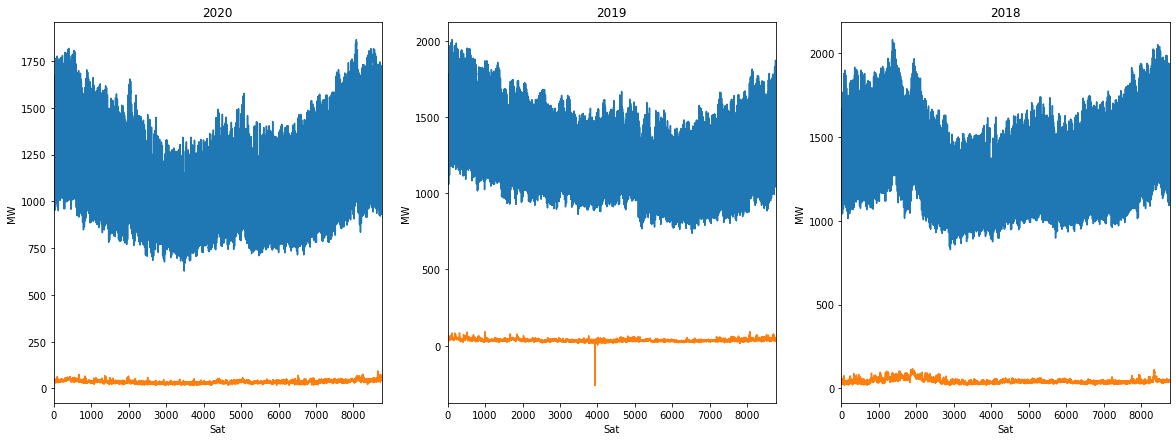

In [16]:
fig,ax = plt.subplots(ncols=3,figsize=(20,7))
ax[0].plot(np.arange(len(file3_2020)),file3_2020["Gubici + Konzum, MWh"], label="Potražnja")

ax[0].plot(np.arange(len(file3_2020)),file3_2020["Gubici, MWh"], label="Gubici")
ax[0].set_title("2020")

ax[0].set_xlabel("Sat")
ax[0].set_ylabel("MW")
ax[0].set_xlim(0,8760)


ax[1].plot(np.arange(len(file3_2019)),file3_2019["Gubici + Konzum, MWh"], label="Potražnja")
ax[1].plot(np.arange(len(file3_2019)),file3_2019["Gubici, MWh"], label="Gubici")
ax[1].set_title("2019")
ax[1].set_xlabel("Sat")
ax[1].set_ylabel("MW")
ax[1].set_xlim(0,8760)
#ax[1].legend()

ax[2].plot(np.arange(len(file3_2018)),file3_2018["Gubici + Konzum, MWh"], label="Potražnja")
ax[2].plot(np.arange(len(file3_2018)),file3_2018["Gubici, MWh"], label="Gubici")
ax[2].set_title("2018")
ax[2].set_xlabel("Sat")
ax[2].set_ylabel("MW")
ax[2].set_xlim(0,8760)
#ax[2].legend()
plt.show()


In [17]:
file3_2019[file3_2019["Gubici, MWh"]<0] #anomalija

,Datum,"Konzum, kWh","Gubici, MWh","Gubici, MWh.1","Gubici + Konzum, kWh",Godina,Sat,Mjesec,Dan_u_godini,Date,Dan_u_sedmici,Dan_u_mjesecu,"Gubici + Konzum, MWh","Konzum, MWh"
3934,13.06.2019 23-24,1170085.0,-261.476,NaN,908609.0,2019,22,6,164,2019-06-13,3,13,908.609,1170.085


Gubici u mreži mogu biti prenosni ili distributivni. Prenosni gubici iznosili su u 2020. godini iznosili 317,2 GWh, odnosno 1,75% od ukupne energije u preenosnom sistemu. 
Prenosni gubici su manji s obzirom da je u pitanju viši naponski nivo. Također, izborom višeg naponskog nivoa smanjuje se veličina provodnika i postiže se ušteda materijala i vrši se bolja regulacija napona. 
Izvještajem o radu DERK-a za 2019. i 2020.  je navedeno da je dugotrajni problem u elektronergetskom sistemu vrijednosti napona iznad vrijednosti propisanih Mrežnim kodeksom, naročito u 400 kV i 220 kV mreži. Glavni uzrok nastanka i trajanja previsokih napona su slabo opterećeni 400 kV dalekovodi u periodima niskog opterećenja konzuma, koji generiraju veliku količinu reaktivne energije. U pogledu rješenja, navodi se eventualna upotreba prigušnica.

Poremećaji u distributivnoj mreži su znatno nepovoljniji radi veće razgranatosti i veličine, te češće podliježu različitim vrstama kvarova.  Distiributivni gubici iznose cca 912,6 GWh ili 9,13% u odnosu na bruto distributivnu potrošnju i kontinuirano se smanjuju. U nastavku su dati dijagrami ukupnih gubitaka i potrošnje el.energije na godišnjem nivou. Vidljivo je da trend povećanja/smanjenja proizvodnje prati i trend povećanja/smanjenja gubitaka el. energije.

<AxesSubplot:title={'center':'2018 - Gubici, MWh'}, xlabel='Mjesec'>

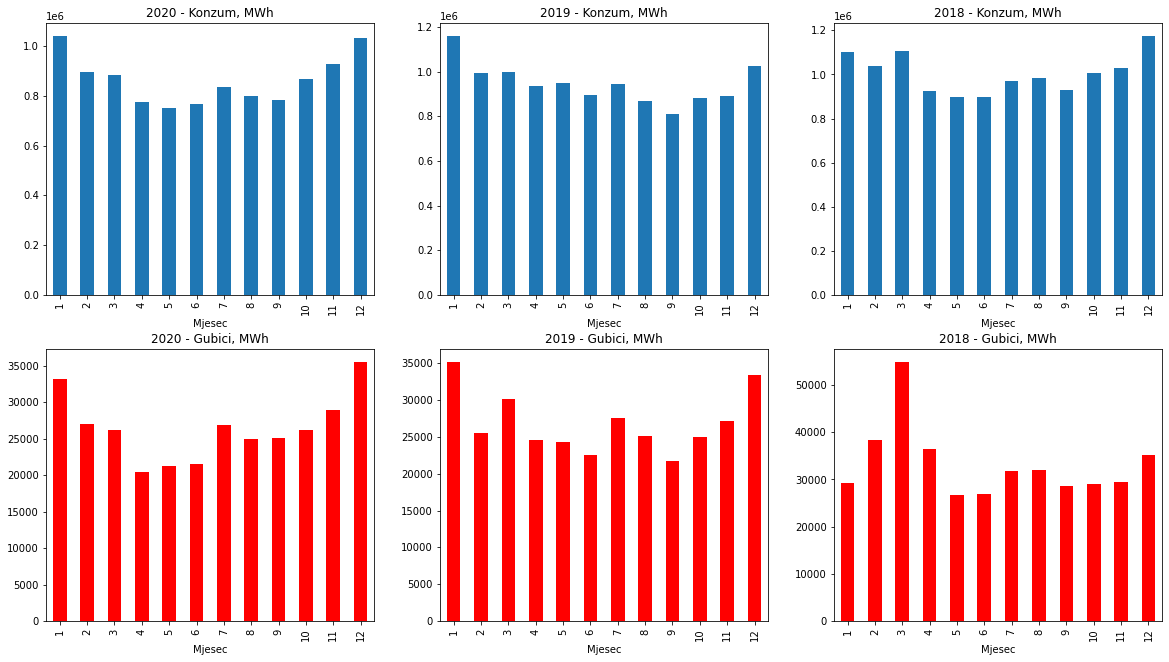

In [18]:
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(20,11))

"Gubici, MWh","Gubici + Konzum, MWh"

file3_2020.groupby("Mjesec").sum()["Konzum, MWh"].plot(kind="bar",ax=ax[0,0],title="2020 - Konzum, MWh")
file3_2019.groupby("Mjesec").sum()["Konzum, MWh"].plot(kind="bar",ax=ax[0,1],title="2019 - Konzum, MWh")
file3_2018.groupby("Mjesec").sum()["Konzum, MWh"].plot(kind="bar",ax=ax[0,2],title="2018 - Konzum, MWh")

file3_2020.groupby("Mjesec").sum()["Gubici, MWh"].plot(kind="bar",ax=ax[1,0],title="2020 - Gubici, MWh",color="red")
file3_2019.groupby("Mjesec").sum()["Gubici, MWh"].plot(kind="bar",ax=ax[1,1],title="2019 - Gubici, MWh",color="red")
file3_2018.groupby("Mjesec").sum()["Gubici, MWh"].plot(kind="bar",ax=ax[1,2],title="2018 - Gubici, MWh",color="red")



Potrošnja el. energije u zimskim nešto veća nego u ljetnim, čemu je vjerovatno uzrok što se određeni broj domaćinstava zimi koristi električnu energiju za grijanje prostora, s tim da se blagi porast javlja u 7. i 8. mjesecu, čemu je vjerovatno uzrok i korištenje uređaja za hlađenje prostora prilikom ekstremno visokih ljetnih temperatura. Minimalna potrošnja se obično javlja početkom maja (1. i 2.5.), dok je maksimalna potrošnja manje predvidiva, ali se u dva slučaja dešava na 31.12.

In [19]:
def find_min(file,name_col):
    minimum=file[name_col].min(axis=0)
    return file[file[name_col]==file[name_col].min()][["Mjesec","Dan_u_mjesecu","Sat"]],minimum
def find_max(file,name_col):
    maximum=file[name_col].max(axis=0)
    return file[file[name_col]==file[name_col].max()][["Mjesec","Dan_u_mjesecu","Sat"]],maximum

In [20]:
#Statistika
date,value=find_min(file3_2020,'Konzum, MWh')
print("Minimum u satu 2020. godine:",value,"MW")
date

Minimum u satu 2020. godine: 605.068 MW


,Mjesec,Dan_u_mjesecu,Sat
3482,5,25,2


In [21]:
date,value=find_min(file3_2019,'Konzum, MWh')
print("Minimum u satu 2019. godine:",value,"MW")
date

Minimum u satu 2019. godine: 714.2669999999999 MW


,Mjesec,Dan_u_mjesecu,Sat
6530,9,30,2


In [22]:
date,value=find_min(file3_2018,'Konzum, MWh')
print("Minimum u satu 2018. godine:",value,"MW")
date

Minimum u satu 2018. godine: 805.412 MW


,Mjesec,Dan_u_mjesecu,Sat
2906,5,2,2


In [23]:
date,value=find_min(BA_file2[BA_file2["Godina"]==2017],"Value")
print("Minimum u satu 2017. godine:",value,"MW")
date

Minimum u satu 2017. godine: 873.44 MW


,Mjesec,Dan_u_mjesecu,Sat
420822,5,2,1


In [24]:
#Statistika
date,value=find_min(BA_file2[BA_file2["Godina"]==2016],"Value")
print("Minimum u satu 2016. godine:",value,"MW")


Minimum u satu 2016. godine: 868.36 MW


In [25]:
#Statistika

date,value=find_max(file3_2020,'Konzum, MWh')
print("Maksimum u satu 2020. godine:",value,"MW")
date

Maksimum u satu 2020. godine: 1803.92 MW


,Mjesec,Dan_u_mjesecu,Sat
8077,12,2,13


In [26]:
date,value=find_max(file3_2019,'Konzum, MWh')
print("Maksimum u satu 2019. godine:",value,"MW")
date

Maksimum u satu 2019. godine: 1944.613 MW


,Mjesec,Dan_u_mjesecu,Sat
113,1,5,17


In [27]:
date,value=find_max(file3_2018,'Konzum, MWh')
print("Maksimum u satu 2018. godine:",value,"MW")
date

Maksimum u satu 2018. godine: 1993.963 MW


,Mjesec,Dan_u_mjesecu,Sat
8441,12,18,17


In [28]:
date,value=find_max(BA_file2[BA_file2["Godina"]==2017],"Value")
print("Maksimum u satu 2017. godine:",value,"MW")
date

Maksimum u satu 2017. godine: 2237.4 MW


,Mjesec,Dan_u_mjesecu,Sat
325458,1,11,16


In [29]:
date,value=find_max(BA_file2[BA_file2["Godina"]==2016],"Value")
print("Maksimum u satu 2016. godine:",value,"MW")
date

Maksimum u satu 2016. godine: 2142.21 MW


,Mjesec,Dan_u_mjesecu,Sat
315960,12,31,16


### Kriva trajanja opterećenja

(0.0, 8760.0)

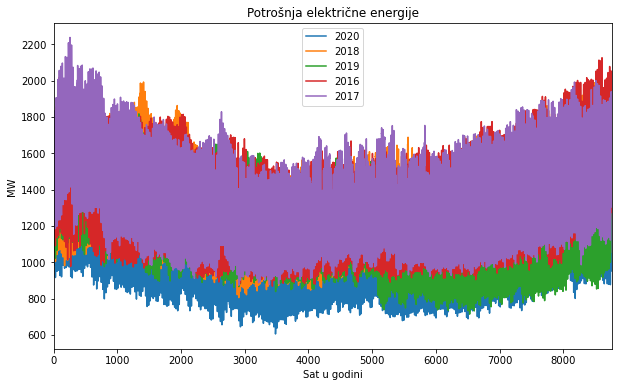

In [30]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca()
ax.plot(np.arange(len(file3_2020)),file3_2020["Konzum, MWh"], label="2020")
ax.plot(np.arange(len(file3_2018)),file3_2018["Konzum, MWh"], label="2018")
ax.plot(np.arange(len(file3_2019)),file3_2019["Konzum, MWh"], label="2019")

ax.plot(np.arange(len(BA_file2[BA_file2["Godina"]==2016])),BA_file2[BA_file2["Godina"]==2016]["Value"], label="2016")
ax.plot(np.arange(len(BA_file2[BA_file2["Godina"]==2017])),BA_file2[BA_file2["Godina"]==2017]["Value"], label="2017")
ax.legend()
ax.set_title("Potrošnja električne energije")
ax.set_xlabel("Sat u godini")
ax.set_ylabel("MW")
plt.xlim(0,8760)

In [31]:
sorted_2020=file3_2020.sort_values(by="Konzum, MWh",ascending=False)
sorted_2019=file3_2019.sort_values(by="Konzum, MWh",ascending=False)
sorted_2018=file3_2018.sort_values(by="Konzum, MWh",ascending=False)

sorted_2016=BA_file2[BA_file2["Godina"]==2016].sort_values(by="Value",ascending=False)
sorted_2017=BA_file2[BA_file2["Godina"]==2017].sort_values(by="Value",ascending=False)

Sa krive opterećenja (Slika ispod) se može vidjeti da je 25% vremena (2000 sati) u 2020. potrošnja viša od cca.1400 MW, s tim da je maksimalna zabilježena 2237 MW (2017. godina). Za prethodne godine je to obično oko 1600 MW.

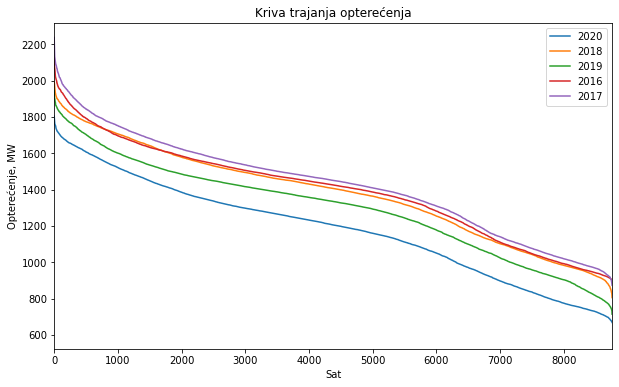

In [32]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca()
ax.plot(np.arange(len(file3_2020)),sorted_2020["Konzum, MWh"], label="2020")
ax.plot(np.arange(len(file3_2018)),sorted_2018["Konzum, MWh"], label="2018")
ax.plot(np.arange(len(file3_2019)),sorted_2019["Konzum, MWh"], label="2019")
ax.plot(np.arange(len(sorted_2016)),sorted_2016["Value"], label="2016")
ax.plot(np.arange(len(sorted_2017)),sorted_2017["Value"], label="2017")
ax.set_xlim(0,8761)
ax.set_ylabel("Opterećenje, MW")
ax.set_xlabel("Sat")
ax.set_title("Kriva trajanja opterećenja")
ax.legend()
# kriva trajanja će se naknadno iskomentarisati


In [33]:
file3_2020.head(2)

,Datum,"Konzum, kWh","Gubici, MWh","Gubici, MWh.1","Gubici + Konzum, kWh",Godina,Sat,Mjesec,Dan_u_godini,Date,Dan_u_sedmici,Dan_u_mjesecu,"Gubici + Konzum, MWh","Konzum, MWh"
0,01.01.2020 00-01,1208647,37.379,NaN,1246026,2020,0,1,1,2020-01-01,2,1,1246.026,1208.647
1,01.01.2020 01-02,1144023,39.612,NaN,1183635,2020,1,1,1,2020-01-01,2,1,1183.635,1144.023


(1.0, 12.0)

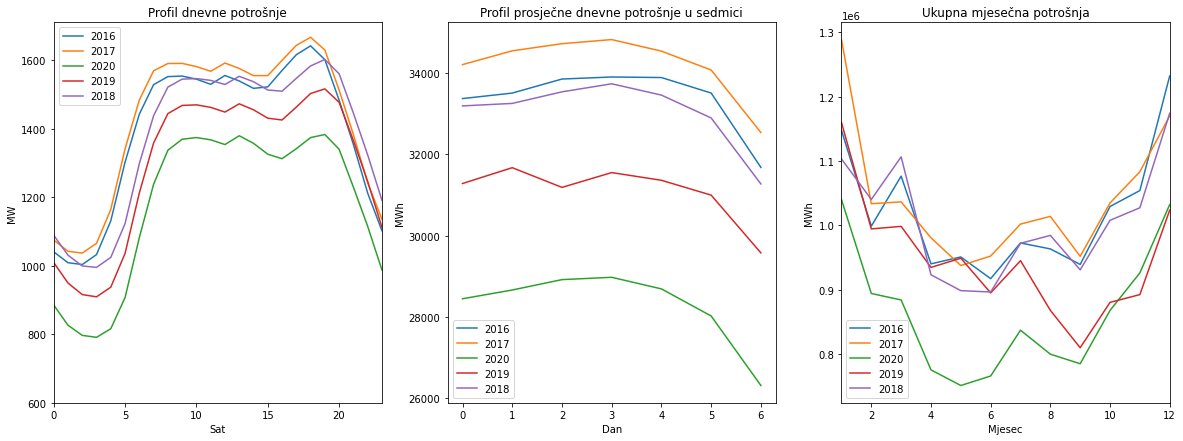

In [34]:
fig,ax = plt.subplots(ncols=3,figsize=(20,7))
# grupisanje po srednjoj vrijednosti po satu u toku godine
BA_file2[BA_file2["Godina"]==2016].groupby("Sat")["Value"].mean().plot(label="2016",ax=ax[0])
BA_file2[BA_file2["Godina"]==2017].groupby("Sat")["Value"].mean().plot(label="2017",ax=ax[0])
file3_2020.groupby("Sat").mean()["Konzum, MWh"].plot(label="2020",ax=ax[0])
file3_2019.groupby("Sat").mean()["Konzum, MWh"].plot(label="2019",ax=ax[0])
file3_2018.groupby("Sat").mean()["Konzum, MWh"].plot(label="2018",ax=ax[0])
ax[0].legend()
ax[0].set_title("Profil dnevne potrošnje")
ax[0].set_xlabel("Sat")
ax[0].set_ylabel("MW")
ax[0].set_xlim(0,23)
ax[0].set_ylim(600)

# sumiranje potrošnje po danima u toku sedmice
f_2016=BA_file2[BA_file2["Godina"]==2016].groupby(["Dan_u_sedmici","Dan_u_godini"])["Value"].sum()
f_2017=BA_file2[BA_file2["Godina"]==2017].groupby(["Dan_u_sedmici","Dan_u_godini"])["Value"].sum()
f_2020=file3_2020.groupby(["Dan_u_sedmici","Dan_u_godini"]).sum()["Konzum, MWh"]
f_2019=file3_2019.groupby(["Dan_u_sedmici","Dan_u_godini"]).sum()["Konzum, MWh"]
f_2018=file3_2018.groupby(["Dan_u_sedmici","Dan_u_godini"]).sum()["Konzum, MWh"]

#prosječna potrošnja po danu u sedmici
f_2016.groupby("Dan_u_sedmici").mean().plot(label="2016",ax=ax[1])
f_2017.groupby("Dan_u_sedmici").mean().plot(label="2017",ax=ax[1])
f_2020.groupby("Dan_u_sedmici").mean().plot(label="2020",ax=ax[1])
f_2019.groupby("Dan_u_sedmici").mean().plot(label="2019",ax=ax[1])
f_2018.groupby("Dan_u_sedmici").mean().plot(label="2018",ax=ax[1])


ax[1].legend()
ax[1].set_title("Profil prosječne dnevne potrošnje u sedmici")
ax[1].set_xlabel("Dan")
ax[1].set_ylabel("MWh")

#Monday=0, Sunday=6.

#ukupna potrošnja po mjesecima u toku godine
grouped_month16=BA_file2[BA_file2["Godina"]==2016].groupby(["Mjesec"])["Value"].sum().plot(label="2016",ax=ax[2])
grouped_month17=BA_file2[BA_file2["Godina"]==2017].groupby(["Mjesec"])["Value"].sum().plot(label="2017",ax=ax[2])

grouped_month20=file3_2020.groupby("Mjesec").sum()["Konzum, MWh"].plot(label="2020",ax=ax[2])
grouped_month19=file3_2019.groupby("Mjesec").sum()["Konzum, MWh"].plot(label="2019",ax=ax[2])
grouped_month18=file3_2018.groupby("Mjesec").sum()["Konzum, MWh"].plot(label="2018",ax=ax[2])


ax[2].legend()
ax[2].set_title("Ukupna mjesečna potrošnja")
ax[2].set_xlabel("Mjesec")
ax[2].set_ylabel("MWh")
ax[2].set_xlim(1,12)



Za svaku godinu je generisan profil dnevne potrošnje po satima, gdje se očekivano može primijetiti da se vršna potrošnja dešava u poslijepodnevnim satima, s tim da je veći dio potrošnje u periodu od (5-20)h, te sredinom sedmice. Potrošnja električne energije bilježi pad vikendom. 

### Usrednjeni profili potražnje

In [35]:
columns1=["Sat","Dan_u_sedmici","Mjesec","Godina","Dan_u_godini","Value"]
columns2=["Sat","Dan_u_sedmici","Mjesec","Godina","Dan_u_godini",'Konzum, MWh']
     
dict1={"Value":'Konzum, MWh'}
BA_file3=BA_file2.rename(columns=dict1)
BA_ALL=pd.concat([BA_file3[columns2],file3_2018[columns2],file3_2019[columns2],file3_2020[columns2]])

In [36]:
BA_ALL=BA_ALL[BA_ALL["Godina"] != 2015] # samo jedna vrijednost postoji 
#za 2015 pa je potrebno izbaciti


Text(-2.700000000000003, 0.5, 'MW')

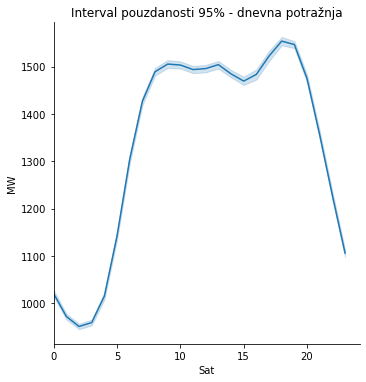

In [37]:
sns.relplot(
    data=BA_ALL, x='Sat', y='Konzum, MWh',kind="line")
plt.title("Interval pouzdanosti 95% - dnevna potražnja")
plt.xlim(0)
plt.xlabel("Sat")
plt.ylabel("MW")

## DIO B

### Preuzimanje podataka sa web stranice

Na web stranici NOS BiH postoje dnevne tabele sa satnim podacima, koje bi se trebale pojedinačno kopirati u Excel fajl. Za ovo je kreiran kod koji kombinira HTML kod web stranice kako bi se automatizovao proces izbora dana i kopiranja podataka. Dobivene fajlove je ipak potrebno na kraju modifikovati radi datuma s obzirom da poteškoće stvaraju dani za koje tabele nisu dostupne. Ovaj dio se može odraditi ručno u kratkom periodu nakon što se dobiju željeni podaci.

In [8]:
#%pip install requests
#%pip install bs4
#%%pip install lxml
import datetime as dt

import requests
from bs4 import BeautifulSoup

import re

import time
from bs4 import BeautifulSoup

# Import webdriver to initialise a browser
from selenium import webdriver
from selenium.webdriver import ActionChains

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By

In [9]:
date_list1=pd.date_range("2020-12-31","2022-01-01", freq="1D").strftime("%d.%m.%Y.")

In [ ]:

# website
url = "https://www.nosbih.ba/bs/ees/graf-potrosnje/"

# Initialize webdriver 
driver = webdriver.Chrome(executable_path=r'C:\\Users\\Ehlimana\\Desktop\\chromedriver.exe')

# Launch Chrome and pass the url
driver.get(url)
dfs=[None]*len(date_list1)
#date selection
for k, value in enumerate(date_list1):
    
    
    # Made a list of all elements that have "day" on the id.
    list_days = driver.find_elements_by_class_name("day")
    # Now I get the len of that list
    count = len(list_days)
    # Loop over each element of the list count
    for i in range(count):
        # And I get the link to the element 
        python_botton = driver.find_elements_by_class_name("day")[i]
         # I will click on the day button.
        if python_botton.get_attribute('class') == "day":
            ActionChains(driver).click(python_botton).perform()
            # Wait for the page to update 
            time.sleep(10)
            # Now parse the page 
            soup = BeautifulSoup(driver.page_source, 'lxml')

   
    
    next3 = driver.find_element_by_name("date").clear()
    next3 = driver.find_element_by_name("date").send_keys(value)#send date info to datebox
    #next3.submit()
    next1 = driver.find_element_by_id("selectDateRegionButton") .click()
   
    ActionChains(driver).click(next1).perform() 
    
    next2 = driver.find_element_by_id("nav-production-table-tab").click()                                      
    ActionChains(driver).click(next2).perform()
    
    
    driver.implicitly_wait(8)
    table1 = driver.find_element_by_id('productionTable')
    
    print(date_list1[k])
    	#table1
    dfs[k]=pd.read_html(driver.find_element_by_xpath('//*[@id="productionTable"]').get_attribute('outerHTML'))[0]
    dfs[k]=dfs[k].assign(Date=create_datarange_2021[k])

In [ ]:
df_tot=pd.concat(dfs,axis=0)
df_tot.to_excel("NOS_BiH_2021.xlsx")

### Otvaranje fajlova

In [3]:
file_NOS_2021=pd.read_excel(r"FILES\ELEKT\NOS_BiH_2021.xlsx",header=0,sheet_name=0)#taabela modifikovana u excelu sa  date index
file_NOS_2020=pd.read_excel(r"FILES\ELEKT\NOS_BiH_2020.xlsx",header=0,sheet_name=0)#taabela modifikovana u excelu sa  date index

In [4]:
file_NOS_2020.head(2)

,Unnamed: 0,Vrijeme,Planirana proizvodnja,Ostvarena proizvodnja,Planirana potrošnja,Ostvarena potrošnja,Date
0,0,01:00,1899.0,1905.32,1211.0,1498.34,11.01.2020.
1,1,02:00,1722.0,1749.79,1090.0,1410.16,11.01.2020.


In [5]:
file_NOS_2021=file_NOS_2021.assign(Mjesec=pd.to_datetime(file_NOS_2021["Date"]).dt.month)
file_NOS_2020=file_NOS_2020.assign(Mjesec=pd.to_datetime(file_NOS_2020["Date"]).dt.month)

In [6]:
file_NOS_2020.head(2)

,Unnamed: 0,Vrijeme,Planirana proizvodnja,Ostvarena proizvodnja,Planirana potrošnja,Ostvarena potrošnja,Date,Mjesec
0,0,01:00,1899.0,1905.32,1211.0,1498.34,11.01.2020.,11
1,1,02:00,1722.0,1749.79,1090.0,1410.16,11.01.2020.,11


Oba fajla imaju praznine u podacima, te se to može vidjeti u narednim ćelijama, s tim da je najmanji broj praznina među planiranim vrijednostima.

In [7]:
print("Ne postoje ostvarene proizvodnje za 2020:")
indices= np.where(pd.isnull(file_NOS_2020))
file_NOS_2020[pd.isnull(file_NOS_2020["Ostvarena proizvodnja"])]["Date"].unique()

Ne postoje ostvarene proizvodnje za 2020:


array(['13.01.2020.', '14.01.2020.', '29.03.2020.', '13.04.2020.',
       '22.04.2020.', '25.04.2020.', '27.04.2020.', '12.05.2020.',
       '13.05.2020.', '18.05.2020.', '21.05.2020.', '22.05.2020.',
       '25.05.2020.', '26.05.2020.', '27.05.2020.', '31.05.2020.',
       '01.06.2020.', '02.06.2020.', '03.06.2020.', '05.06.2020.',
       '06.06.2020.', '08.06.2020.', '15.06.2020.', '16.06.2020.',
       '17.06.2020.', '22.06.2020.', '30.06.2020.', '06.07.2020.',
       '08.07.2020.', '09.07.2020.', '10.07.2020.', '11.07.2020.',
       '13.07.2020.', '19.07.2020.', '20.07.2020.', '21.07.2020.',
       '22.07.2020.', '23.07.2020.', '24.07.2020.', '27.07.2020.',
       '03.08.2020.', '04.08.2020.', '05.08.2020.', '06.08.2020.',
       '07.08.2020.', '09.08.2020.', '10.08.2020.', '11.08.2020.',
       '25.08.2020.', '26.08.2020.', '20.09.2020.', '23.09.2020.',
       '24.09.2020.', '25.09.2020.', '26.09.2020.', '06.10.2020.',
       '07.10.2020.', '25.10.2020.', '02.11.2020.', '07.11.202

In [8]:
print("Ne postoje ostvarene potrošnje za pojedine sate u danima 2020:")
indices= np.where(pd.isnull(file_NOS_2020))
file_NOS_2020[pd.isnull(file_NOS_2020["Ostvarena potrošnja"])]["Date"].unique()

Ne postoje ostvarene potrošnje za pojedine sate u danima 2020:


array(['13.01.2020.', '14.01.2020.', '29.03.2020.', '13.04.2020.',
       '14.04.2020.', '15.04.2020.', '16.04.2020.', '17.04.2020.',
       '27.04.2020.', '28.04.2020.', '02.05.2020.', '07.05.2020.',
       '13.05.2020.', '15.05.2020.', '18.05.2020.', '21.05.2020.',
       '22.05.2020.', '25.05.2020.', '26.05.2020.', '27.05.2020.',
       '31.05.2020.', '01.06.2020.', '02.06.2020.', '03.06.2020.',
       '05.06.2020.', '06.06.2020.', '08.06.2020.', '15.06.2020.',
       '16.06.2020.', '17.06.2020.', '22.06.2020.', '30.06.2020.',
       '06.07.2020.', '08.07.2020.', '09.07.2020.', '10.07.2020.',
       '13.07.2020.', '19.07.2020.', '20.07.2020.', '21.07.2020.',
       '22.07.2020.', '24.07.2020.', '27.07.2020.', '03.08.2020.',
       '04.08.2020.', '05.08.2020.', '06.08.2020.', '09.08.2020.',
       '10.08.2020.', '11.08.2020.', '16.08.2020.', '25.08.2020.',
       '26.08.2020.', '15.09.2020.', '20.09.2020.', '23.09.2020.',
       '24.09.2020.', '25.09.2020.', '26.09.2020.', '06.10.202

In [9]:
print("Ne postoje ostvarene potrošnje za 2021:")
indices= np.where(pd.isnull(file_NOS_2021))
file_NOS_2021[pd.isnull(file_NOS_2021["Ostvarena proizvodnja"])]["Date"].unique()

Ne postoje ostvarene potrošnje za 2021:


array(['02.01.2021', '12.02.2021', '15.02.2021', '24.02.2021',
       '11.03.2021', '17.03.2021', '19.03.2021', '24.03.2021',
       '28.03.2021', '29.03.2021', '30.03.2021', '06.04.2021',
       '08.04.2021', '09.04.2021', '13.04.2021', '15.04.2021',
       '19.04.2021', '27.04.2021', '04.05.2021', '05.05.2021',
       '07.05.2021', '11.05.2021', '13.06.2021', '14.06.2021',
       '05.07.2021', '07.07.2021', '09.07.2021', '13.07.2021',
       '16.07.2021', '26.07.2021', '28.07.2021', '29.07.2021',
       '30.07.2021', '31.07.2021', '26.08.2021', '21.10.2021',
       '24.10.2021', '25.10.2021', '26.10.2021', '05.11.2021',
       '21.12.2021', '22.12.2021'], dtype=object)

In [10]:
print("Ne postoje ostvarene potrošnje za pojedine sate u danima 2020:")
indices= np.where(pd.isnull(file_NOS_2020))
file_NOS_2020[pd.isnull(file_NOS_2020["Planirana proizvodnja"])]["Date"].unique()

Ne postoje ostvarene potrošnje za pojedine sate u danima 2020:


array(['25.03.2020.', '26.03.2020.', '25.10.2020.'], dtype=object)

In [11]:
print("Ne postoje ostvarene potrošnje za pojedine sate u danima2020:")
indices= np.where(pd.isnull(file_NOS_2020))
file_NOS_2020[pd.isnull(file_NOS_2020["Planirana potrošnja"])]["Date"].unique()

Ne postoje ostvarene potrošnje za pojedine sate u danima2020:


array(['25.03.2020.', '26.03.2020.', '29.11.2020.', '30.11.2020.',
       '01.12.2020.'], dtype=object)

In [12]:
print("Ne postoje ostvarene potrošnje za pojedine sate u danima 2021:")
indices= np.where(pd.isnull(file_NOS_2021))
file_NOS_2021[pd.isnull(file_NOS_2021["Planirana proizvodnja"])]["Date"].unique()

Ne postoje ostvarene potrošnje za pojedine sate u danima 2021:


array(['15.07.2021', '16.07.2021', '30.07.2021', '31.07.2021',
       '31.10.2021', '21.11.2021'], dtype=object)

In [13]:
print("Ne postoje ostvarene potrošnje za pojedine sate u danima 2021:")
indices= np.where(pd.isnull(file_NOS_2021))
file_NOS_2021[pd.isnull(file_NOS_2021["Planirana potrošnja"])]["Date"].unique()

Ne postoje ostvarene potrošnje za pojedine sate u danima 2021:


array([], dtype=object)

In [14]:
file_NOS_2020.rename(columns = {"Planirana proizvodnja":"Planirana proizvodnja-2020.",
                                "Ostvarena proizvodnja":"Ostvarena proizvodnja-2020.",
                                "Planirana potrošnja":"Planirana potrošnja-2020.",
                                "Ostvarena potrošnja":"Ostvarena potrošnja-2020."}, inplace = True)

In [15]:
file_NOS_2021.rename(columns = {"Planirana proizvodnja":"Planirana proizvodnja-2021.",
                                "Ostvarena proizvodnja":"Ostvarena proizvodnja-2021.",
                                "Planirana potrošnja":"Planirana potrošnja-2021.",
                                "Ostvarena potrošnja":"Ostvarena potrošnja-2021."}, inplace = True)

Može se primijetiti da je ostvarena proizvodnja nekada značajno veća od planirane proizvodnje.

Text(0, 0.5, 'Proizvodnja, MW')

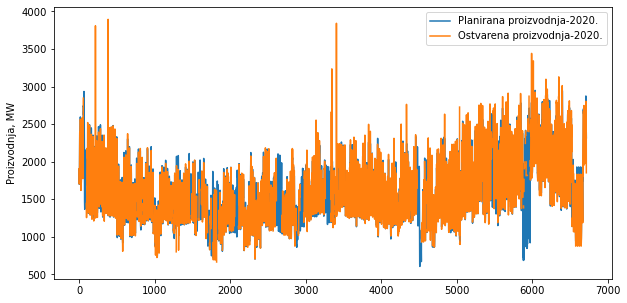

In [16]:
file_NOS_2020[["Planirana proizvodnja-2020.",'Ostvarena proizvodnja-2020.']].astype(float).plot(figsize=(10,5))
plt.legend()
plt.ylabel("Proizvodnja, MW")

In [17]:
file_NOS_2020[file_NOS_2020["Ostvarena proizvodnja-2020."]>3000]

,Unnamed: 0,Vrijeme,Planirana proizvodnja-2020.,Ostvarena proizvodnja-2020.,Planirana potrošnja-2020.,Ostvarena potrošnja-2020.,Date,Mjesec
217,2,03:00,1281.0,3808.50,820.0,3027.57,30.03.2020.,3
385,2,03:00,1297.0,3893.97,1003.0,3176.49,06.04.2020.,6
3348,13,14:00,1714.0,3234.76,1397.0,2578.02,07.08.2020.,7
3409,2,03:00,1301.0,3841.68,753.0,2347.23,10.08.2020.,10
5994,18,19:00,2698.0,3440.91,1740.0,2419.59,01.12.2020.,1
6017,17,18:00,2913.0,3340.83,1847.0,2090.77,02.12.2020.,2
6184,16,17:00,2826.0,3097.12,1646.0,1780.24,09.12.2020.,9
6354,18,19:00,2698.0,3128.20,1746.0,2232.23,16.12.2020.,12
6400,16,17:00,2944.0,3012.00,1824.0,1677.92,18.12.2020.,12


Text(0, 0.5, 'Proizvodnja, MW')

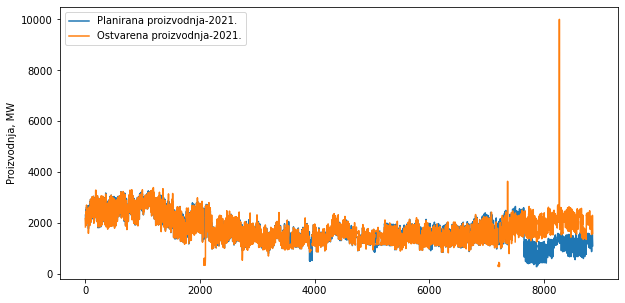

In [18]:
file_NOS_2021[["Planirana proizvodnja-2021.","Ostvarena proizvodnja-2021."]].astype(float).plot(figsize=(10,5))
plt.legend()
plt.ylabel("Proizvodnja, MW")

In [19]:
file_NOS_2021[file_NOS_2021["Ostvarena proizvodnja-2021."]>8000] #anomalija ili ekstrem

,Unnamed: 0,Vrijeme,Planirana proizvodnja-2021.,Ostvarena proizvodnja-2021.,Planirana potrošnja-2021.,Ostvarena potrošnja-2021.,Date,Mjesec
8274,17,18:00,1525.0,9999.99,1747,9999.99,07.12.2021,7


Na mjesečnoj bazi, planirana proivodnja je sumarno uvijek veća od ostvarene, dok je ostvarena potrošnja u 2020. godini u zimskim mjesecima sumarno bila veća od planirane (iako je generalno tada zabilježen pad potrošnje usljed isključenja nekih velikih potrošača). Ovo nije slučaj u 2021. godini, ali se u 2021. godini u zimskim mjesecima bilježi značajno veća ostvarena proizvodnja od planirane, što može biti posljedica dobrih hidroloških prilika, te povećane proizvodnje iz HE.

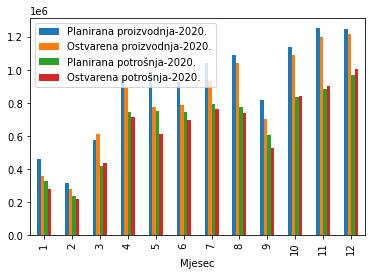

In [20]:
file_NOS_2020.groupby("Mjesec")[["Planirana proizvodnja-2020.",'Ostvarena proizvodnja-2020.',"Planirana potrošnja-2020.", "Ostvarena potrošnja-2020."]].sum().plot(kind="bar")
plt.show()

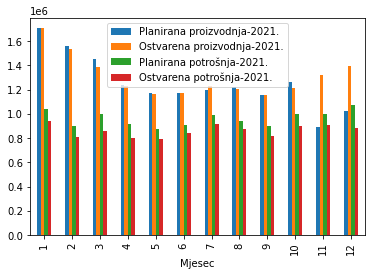

In [21]:
file_NOS_2021.groupby("Mjesec")[["Planirana proizvodnja-2021.",'Ostvarena proizvodnja-2021.',"Planirana potrošnja-2021.", "Ostvarena potrošnja-2021."]].sum().plot(kind="bar")
plt.show()

<AxesSubplot:>

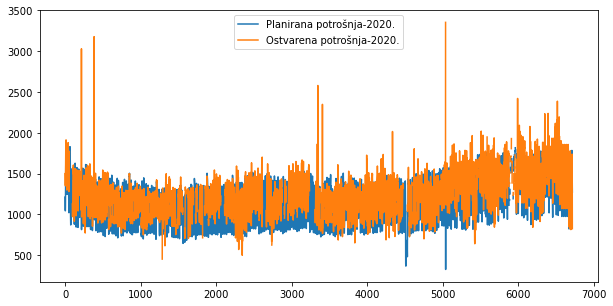

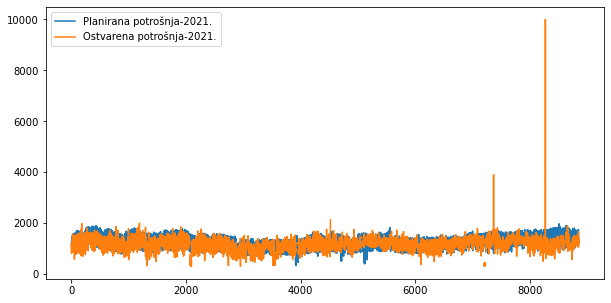

In [93]:
file_NOS_2020[["Planirana potrošnja-2020.", "Ostvarena potrošnja-2020."]].astype(float).plot(figsize=(10,5))
file_NOS_2021[["Planirana potrošnja-2021.", "Ostvarena potrošnja-2021."]].plot(figsize=(10,5))

In [94]:
file_NOS_2021[file_NOS_2021["Ostvarena potrošnja-2021."]>2000]

,Unnamed: 0,Vrijeme,Planirana proizvodnja-2021.,Ostvarena proizvodnja-2021.,Planirana potrošnja-2021.,Ostvarena potrošnja-2021.,Date,Mjesec
1187,10,11:00,3192.0,3291.37,1660,2004.17,19.02.2021,2
4521,9,10:00,2008.0,2030.81,1376,2131.87,07.07.2021,7
7369,1,02:00,1174.0,3643.92,1165,3902.40,31.10.2021,10
7370,2,02:00,NaN,3643.92,815,3902.40,31.10.2021,10
8274,17,18:00,1525.0,9999.99,1747,9999.99,07.12.2021,7


In [95]:
file_NOS_2020[file_NOS_2020["Ostvarena potrošnja-2020."]>2000]

,Unnamed: 0,Vrijeme,Planirana proizvodnja-2020.,Ostvarena proizvodnja-2020.,Planirana potrošnja-2020.,Ostvarena potrošnja-2020.,Date,Mjesec
217,2,03:00,1281.0,3808.50,820.0,3027.57,30.03.2020.,3
385,2,03:00,1297.0,3893.97,1003.0,3176.49,06.04.2020.,6
3348,13,14:00,1714.0,3234.76,1397.0,2578.02,07.08.2020.,7
3409,2,03:00,1301.0,3841.68,753.0,2347.23,10.08.2020.,10
4337,18,19:00,2094.0,2762.50,1254.0,2014.36,17.09.2020.,9
5040,1,02:00,972.0,2726.25,1023.0,3351.51,25.10.2020.,10
5512,16,17:00,2447.0,2768.13,1677.0,2019.25,13.11.2020.,11
5994,18,19:00,2698.0,3440.91,1740.0,2419.59,01.12.2020.,1
6017,17,18:00,2913.0,3340.83,1847.0,2090.77,02.12.2020.,2
6023,23,00:00,2068.0,2277.52,1540.0,2018.68,03.12.2020.,3


In [96]:
print("Broj sati u mjesecu kada je ostvarena proizvodnja veća od planirane u 2020.:")
print(file_NOS_2020[file_NOS_2020["Ostvarena proizvodnja-2020."]>file_NOS_2020["Planirana proizvodnja-2020."]][["Mjesec","Date"]].groupby("Mjesec").count())

print("Broj sati u mjesecu kada je ostvarena proizvodnja veća od planirane u 2021.:")
print(file_NOS_2021[file_NOS_2021["Ostvarena proizvodnja-2021."]>file_NOS_2021["Planirana proizvodnja-2021."]][["Mjesec","Date"]].groupby("Mjesec").count())

Broj sati u mjesecu kada je ostvarena proizvodnja veća od planirane u 2020.:
        Date
Mjesec      
1         98
2         66
3        108
4        248
5        190
6        222
7        326
8        246
9        216
10       269
11       320
12       298
Broj sati u mjesecu kada je ostvarena proizvodnja veća od planirane u 2021.:
        Date
Mjesec      
1        202
2        244
3        253
4        314
5        296
6        337
7        444
8        258
9        314
10       256
11       560
12       573


In [97]:
print("Broj sati u mjesecu kada je ostvarena potrošnja veća od planirane u 2020.:")
print(file_NOS_2020[file_NOS_2020["Ostvarena potrošnja-2020."]>file_NOS_2020["Planirana potrošnja-2020."]][["Mjesec","Date"]].groupby("Mjesec").count())


print("Broj sati u mjesecu kada je ostvarena potrošnja veća od planirane u 2021.:")
print(file_NOS_2021[file_NOS_2021["Ostvarena potrošnja-2021."]>file_NOS_2021["Planirana potrošnja-2021."]][["Mjesec","Date"]].groupby("Mjesec").count())

Broj sati u mjesecu kada je ostvarena potrošnja veća od planirane u 2020.:
        Date
Mjesec      
1        126
2        104
3        173
4        361
5        352
6        386
7        386
8        315
9        278
10       381
11       406
12       493
Broj sati u mjesecu kada je ostvarena potrošnja veća od planirane u 2021.:
        Date
Mjesec      
1        130
2        185
3        177
4        130
5        208
6        281
7        310
8        271
9        155
10       224
11       220
12       108


# Prekogranični tokovi

# Reference

<br>https://www.nosbih.ba/bs/ees/graf-potrosnje/
<br>https://transparency.entsoe.eu/dashboard/show
<br>https://www.entsoe.eu/data/